# Proyecto ML de principio a fin

Don Gerón nos recomienda en su libro seguir los siguientes pasos:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Trataremos de realizar los mismos pasos en la presente notebook! 😃

In [13]:
# Importaciones
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

## Look at the big picture
Debemos construir un modelo para que prediga la media de precios de alojamientos en California, utilizando los datos censales.

Lo siguiente que debemos hacer es **fraccionar el problema**. Para esto, tenemos que conseguir toda la información necesaria; pero lo más importante es: ¿Qué queremos hacer? ¿Qué herramientas tenemos?. Tenemos un _pipeline_ que nos ayudará a desarrollar el modelo:

![pipeline](../images/1.png)

Tenemos que definir una **medida de rendimiento** o performance: Lo típico para problemas de regresión es utilizar el error de la raíz cuadrática media (RMSE, síglas en inglés):

$$RMSE(X,h) = \sqrt{\frac{1}{m} + \sum_{i = 1}^{m}(h(x^{i})-y^{i})^{2}}$$

Realizamos un chequeo de lo que definimos y, si estamos re seguros, nos ponemos a construir el modelo (_como Bob el Constructor (?)_)

## Get the data

Ahora, debemos crearnos un entorno de trabajo (es recomendable crear un entorno virtual, para solo trabajar con las librerías necesarias).
Estaremos analizando el dataset de censos en California, y esta la tenemos disponible en el [repositorio del libro](https://github.com/ageron/handson-ml2). Nosotros tendremos la facilidad de ya tenerlo descargado y disponible en el actual repositorio. Procedemos analizarlo!

In [4]:
HOUSING_PATH = "../datasets/housing.csv"
housing = pd.read_csv(HOUSING_PATH)
housing.head(10) # Obtenemos los primeros 10 registros del dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [5]:
housing.info() # Podemos obtener la información de cada feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Lo primero que salta a la vista es que `total_bedrooms` tiene menos cantidad de datos no nulos que el resto.

Luego vemos que `ocean_proximity` tiene valores categóricos. Veamos esto en detalle:

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

También podemos ver valores numéricos de interés que describen cada feature (valores nulos son ignorados):

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Como un buen complemento, podemos usar histogramas para visualizar los datos

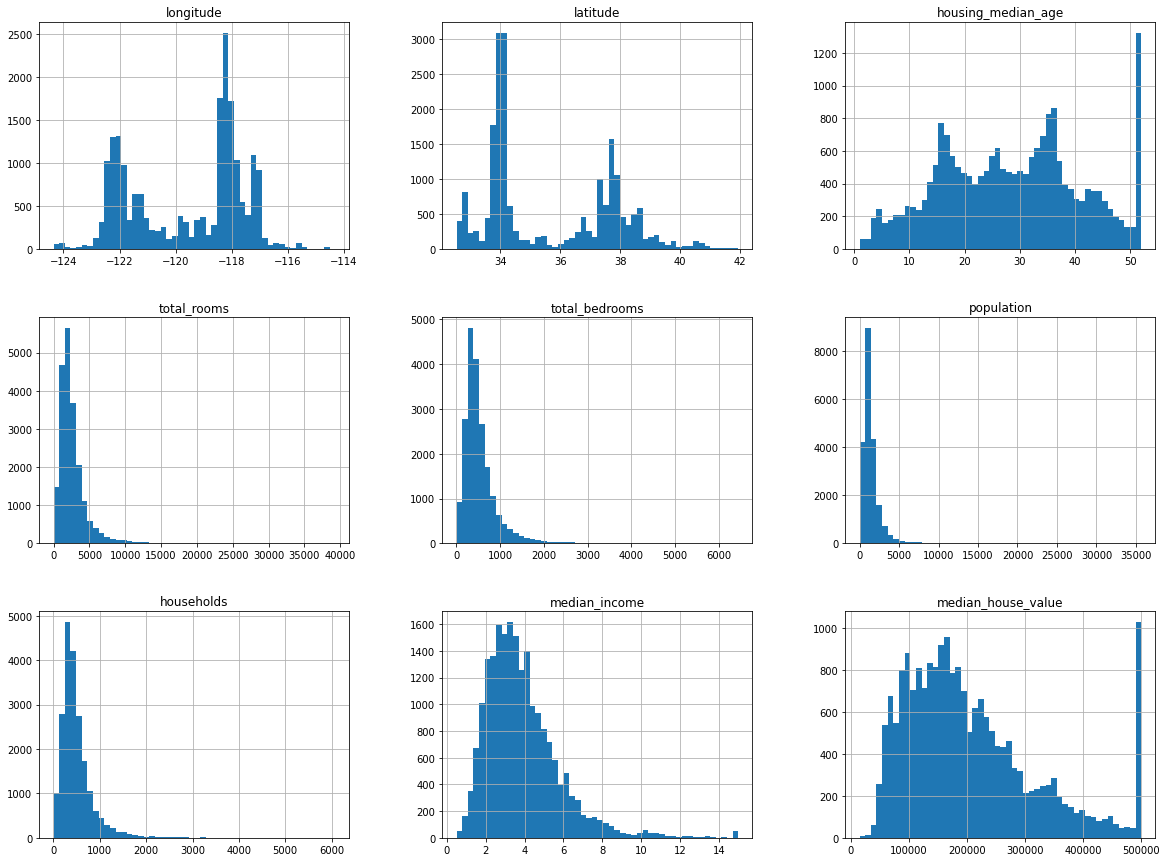

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Ahora vamos a crear datos de entrenamiento, utilizando la librería de Scikit-Learn.

Algo importante que debo tener en cuesta es que no deberíamos ver el conjunto de test hasta que terminemos, debido a que podemos llegar a hacer "trampa" y detectar algún patrón, por lo que nos llevaría a elegir un modelo "correcto" con casi ningún error!

El conjunto de test hay que usarlo recién al final y no antes!

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Un pajarito nos dice que para el proyecto va a ser importante tener en cuenta la feature `median_income` para construir el modelo. Por lo que, debemos ver si esto es una variable representativa (ya tenemos unos indicios si vemos el histograma).

Creemos una nueva feature `income_cat` para ver esto en mayor detalle:

<AxesSubplot:>

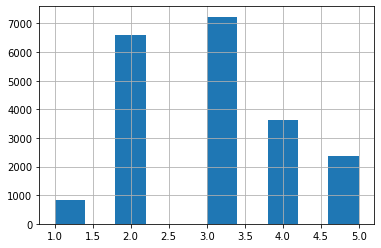

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

Una vez obtenido esto, debemos obtener una muestra estratificada basada en la nueva feature, utilizando `StratifiedShuffleSplit` de Scikit-Learn

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Veamos las proporciones del set estratificado

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Comparemosla con el dataset

In [16]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [19]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Si bien, el error es relativamente pequeño, esto nos puede afectar enormemente si tenemos un dataset pequeño. Ya podemos borrar `income_cat`

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize the data to gain insights

Veamos un poco mejor nuestros datos

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

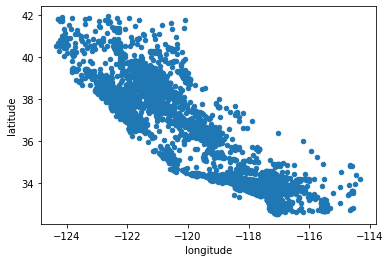

In [22]:
housing = strat_train_set.copy() # Hago una copia de la muestra estratificado y entrenada
housing.plot(kind="scatter", x="longitude", y="latitude") # Ploteo mis datos

En un vistazo, vemos que se parece a California pero debemos mejorar un poco más esto. Veamos la densidad:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

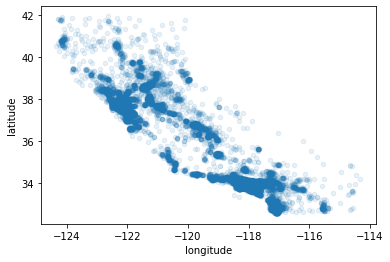

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Ahora tenemos algo mejor. Pero "más mejor" será si agregamos colores para representar mejor la densidad:

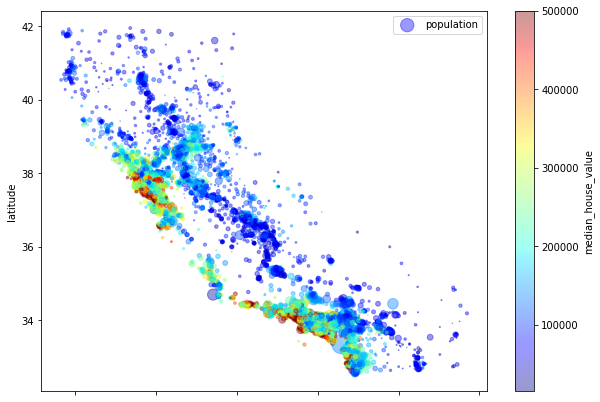

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                 s=housing["population"]/100, label="population", figsize=(10,7),
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()